## Load Data from CSVs

In [1]:
import unicodecsv

def readData(filename):
    with open('data/' + filename + '.csv', 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)


In [2]:
enrollments = readData('enrollments')
enrollments[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', '2014-11-10'),
             ('cancel_date', '2015-01-14'),
             ('days_to_cancel', '65'),
             ('is_udacity', 'True'),
             ('is_canceled', 'True')])

In [3]:
daily_engagement = readData('daily_engagement')
daily_engagement[0]

OrderedDict([('acct', '0'),
             ('utc_date', '2015-01-09'),
             ('num_courses_visited', '1.0'),
             ('total_minutes_visited', '11.6793745'),
             ('lessons_completed', '0.0'),
             ('projects_completed', '0.0')])

In [4]:
project_submissions = readData('project_submissions')
project_submissions[0]

OrderedDict([('creation_date', '2015-01-14'),
             ('completion_date', '2015-01-16'),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Fixing Data Types

In [5]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', datetime.datetime(2014, 11, 10, 0, 0)),
             ('cancel_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('days_to_cancel', 65),
             ('is_udacity', True),
             ('is_canceled', True)])

In [6]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

OrderedDict([('acct', '0'),
             ('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0)])

In [7]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Investigating the Data

In [8]:
## Rename the "acct" column in the daily_engagement table to "account_key".
def rename_column(d, old, new):
    d[new] = d[old]
    del d[old]

for engagement in daily_engagement:
    rename_column(engagement, 'acct', 'account_key')

daily_engagement[0]['account_key']

'0'

In [9]:
def unique_students(data):
    return set([v['account_key'] for v in data])

def number_of_unique_students(data):
    return len(unique_students(data))


In [10]:
## Find the total number of rows and the number of unique students (account keys) in each table.

enrollment_num_rows = len(enrollments)
enrollment_num_unique_students = number_of_unique_students(enrollments)
'enrollment_num_rows = {}, enrollment_num_unique_students = {}'.format(enrollment_num_rows, enrollment_num_unique_students)

'enrollment_num_rows = 1640, enrollment_num_unique_students = 1302'

In [11]:
engagement_num_rows = len(daily_engagement)
engagement_num_unique_students = number_of_unique_students(daily_engagement)
'engagement_num_rows = {}, engagement_num_unique_students = {}'.format(engagement_num_rows, engagement_num_unique_students)

'engagement_num_rows = 136240, engagement_num_unique_students = 1237'

In [12]:
submission_num_rows = len(project_submissions)
submission_num_unique_students = number_of_unique_students(project_submissions)
'submission_num_rows = {}, submission_num_unique_students = {}'.format(submission_num_rows, submission_num_unique_students)

'submission_num_rows = 3642, submission_num_unique_students = 743'

## Missing Engagement Records

In [13]:
# Find any one student enrollments where the student is missing from the daily engagement table.
# Output that enrollment.
unique_enrollmet_students = unique_students(enrollments)
unique_engagement_students = unique_students(daily_engagement)

for enrollment in enrollments:
    if enrollment['account_key'] not in unique_engagement_students:
        print(enrollment)
        break

OrderedDict([('account_key', '1219'), ('status', 'canceled'), ('join_date', datetime.datetime(2014, 11, 12, 0, 0)), ('cancel_date', datetime.datetime(2014, 11, 12, 0, 0)), ('days_to_cancel', 0), ('is_udacity', False), ('is_canceled', True)])


## Checking for More Problem Records

In [14]:
## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.

number_of_surprising_data_points = 0
for enrollment in enrollments:
    if enrollment['account_key'] not in unique_engagement_students and not enrollment['join_date'] == enrollment['cancel_date']:
        number_of_surprising_data_points += 1
        
number_of_surprising_data_points

3

## Tracking Down the Remaining Problems

In [15]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [16]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [17]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print(len(non_udacity_enrollments))
print(len(non_udacity_engagement))
print(len(non_udacity_submissions))

1622
135656
3634


## Refining the Question

In [18]:
## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = dict()
for enrollment in non_udacity_enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel'] > 7:
        if enrollment['account_key'] not in paid_students or enrollment['join_date'] > paid_students[enrollment['account_key']]:
            paid_students[enrollment['account_key']] = enrollment['join_date']

len(paid_students)

995

In [19]:
paid_students['108']

datetime.datetime(2015, 4, 20, 0, 0)

## Getting Data from First Week

In [20]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return 0 <= time_delta.days < 7

def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

In [21]:
## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)
        
len(paid_engagement_in_first_week)

6919

## Exploring Student Engagement

In [22]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')        
len(engagement_by_account)

995

In [23]:
engagement_by_account['0'];

In [24]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def describe_data(data):
    print("Mean: {}".format(np.around(np.mean(data), decimals=2)))
    print('Standard deviation: {}'.format(np.around(np.std(data), decimals=2)))
    print('Minimum: {}'.format(np.min(data)))
    print('Maximum: {} [{} days]'.format(np.around(np.max(data), decimals=2), np.around(np.max(data) / 60 / 24, decimals=2)))
    plt.hist(data)

# Summarize the data about minutes spent in the classroom
total_minutes = list(total_minutes_by_account.values())
describe_data(total_minutes)

Mean: 306.71
Standard deviation: 413.0
Minimum: 0.0
Maximum: 3564.73 [2.48 days]


## Debugging Data Analysis Code

In [26]:
# find account with highest total_minutes_visited
sorted(total_minutes_by_account.items(), key=lambda x: x[1], reverse=True);

In [27]:
# '108' has 10568.1 minutes which is more than 7 days
for eba in engagement_by_account['108']:
    print(eba['utc_date'], eba['total_minutes_visited'])

2015-04-20 00:00:00 25.9137858334
2015-04-21 00:00:00 3.40682316667
2015-04-22 00:00:00 99.1186611667
2015-04-23 00:00:00 35.8316206667
2015-04-24 00:00:00 0.0
2015-04-25 00:00:00 0.0
2015-04-26 00:00:00 0.0


## Lessons Completed in First Week

In [28]:
## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
total_lessons_by_account = sum_grouped_items(engagement_by_account, 'lessons_completed')

Mean: 1.64
Standard deviation: 3.0
Minimum: 0
Maximum: 36 [0.02 days]


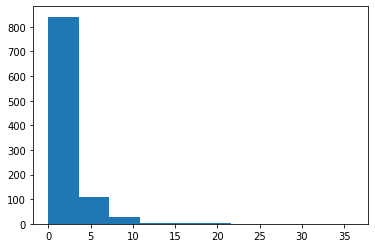

In [29]:
total_lessons = list(total_lessons_by_account.values())
describe_data(total_lessons)

## Number of Visits in First Week

Mean: 2.87
Standard deviation: 2.26
Minimum: 0
Maximum: 7 [0.0 days]


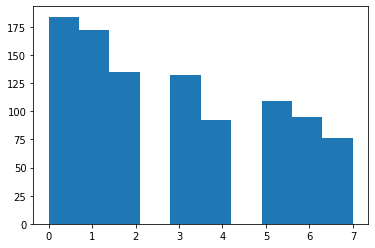

In [30]:
## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
for engagement in daily_engagement:
    engagement['has_visited'] = 1 if engagement['total_minutes_visited'] > 0 else 0

total_days_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
total_days = list(total_days_by_account.values())
describe_data(total_days)

## Splitting out Passing Students

In [31]:
## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']
pass_subway_project = set()

for submission in paid_submissions:
    account = submission['account_key']
    if submission['lesson_key'] in subway_project_lesson_keys:
        if submission['assigned_rating'] == 'PASSED' or submission['assigned_rating'] == 'DISTINCTION':
            pass_subway_project.add(account)
            
len(pass_subway_project)

647

In [32]:
passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print(len(passing_engagement))
print(len(non_passing_engagement))

4527
2392


## Comparing the Two Student Groups

passing engagement:
Mean: 394.59
Standard deviation: 448.5
Minimum: 0.0
Maximum: 3564.73 [2.48 days]

non passing engagement:
Mean: 143.33
Standard deviation: 269.54
Minimum: 0.0
Maximum: 1768.52 [1.23 days]


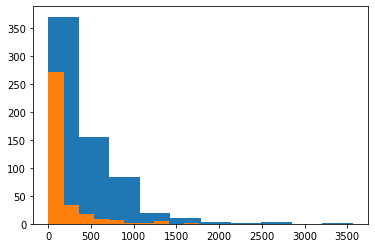

In [33]:
## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

def compare_student_groups(field_name):
    print('passing engagement:')
    passing_engagement_by_account = group_data(passing_engagement, 'account_key') 
    passing_total_minutes_by_account = sum_grouped_items(passing_engagement_by_account, field_name)
    passing_total_minutes = list(passing_total_minutes_by_account.values())
    describe_data(passing_total_minutes)

    print('\nnon passing engagement:')
    non_passing_engagement_by_account = group_data(non_passing_engagement, 'account_key') 
    non_passing_total_minutes_by_account = sum_grouped_items(non_passing_engagement_by_account, field_name)
    non_passing_total_minutes = list(non_passing_total_minutes_by_account.values())
    describe_data(non_passing_total_minutes)

compare_student_groups('total_minutes_visited')

passing engagement:
Mean: 2.05
Standard deviation: 3.14
Minimum: 0
Maximum: 36 [0.02 days]

non passing engagement:
Mean: 0.86
Standard deviation: 2.55
Minimum: 0
Maximum: 27 [0.02 days]


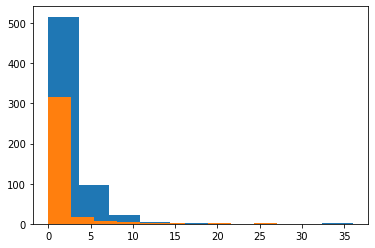

In [34]:
compare_student_groups('lessons_completed')

passing engagement:
Mean: 3.38
Standard deviation: 2.26
Minimum: 0
Maximum: 7 [0.0 days]

non passing engagement:
Mean: 1.91
Standard deviation: 1.91
Minimum: 0
Maximum: 7 [0.0 days]


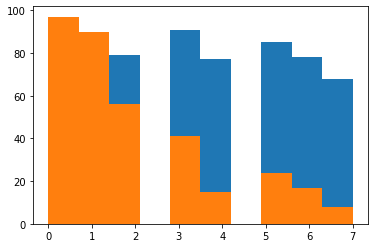

In [35]:
compare_student_groups('has_visited')

## Making Histograms

([array([3.632e+03, 5.300e+02, 2.350e+02, 7.600e+01, 2.700e+01, 1.500e+01,
         4.000e+00, 4.000e+00, 3.000e+00, 1.000e+00]),
  array([2.234e+03, 1.120e+02, 2.600e+01, 1.200e+01, 4.000e+00, 1.000e+00,
         3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])],
 array([   0.        ,  103.08831967,  206.17663933,  309.264959  ,
         412.35327867,  515.44159833,  618.529918  ,  721.61823767,
         824.70655734,  927.794877  , 1030.88319667]),
 <a list of 2 Lists of Patches objects>)

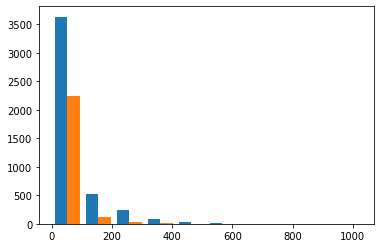

In [36]:
## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.
%matplotlib inline
import matplotlib.pyplot as plt

passing_minutes_hist = []
for engagament in passing_engagement:
    passing_minutes_hist.append(engagament['total_minutes_visited'])

non_passing_minutes_hist = []
for engagament in non_passing_engagement:
    non_passing_minutes_hist.append(engagament['total_minutes_visited'])

plt.hist([passing_minutes_hist, non_passing_minutes_hist])

([array([4.265e+03, 1.680e+02, 5.800e+01, 1.500e+01, 6.000e+00, 1.200e+01,
         2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00]),
  array([2.338e+03, 2.900e+01, 1.000e+01, 7.000e+00, 0.000e+00, 7.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00])],
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 2 Lists of Patches objects>)

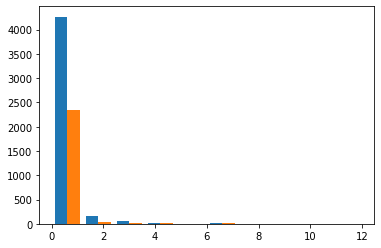

In [37]:
passing_lessons_hist = []
for engagament in passing_engagement:
    passing_lessons_hist.append(engagament['lessons_completed'])

non_passing_lessons_hist = []
for engagament in non_passing_engagement:
    non_passing_lessons_hist.append(engagament['lessons_completed'])

plt.hist([passing_lessons_hist, non_passing_lessons_hist])

([array([2337., 2190.]), array([1729.,  663.])],
 array([0. , 0.5, 1. ]),
 <a list of 2 Lists of Patches objects>)

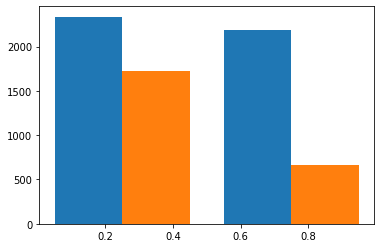

In [38]:
passing_days_hist = []
for engagament in passing_engagement:
    passing_days_hist.append(engagament['has_visited'])

non_passing_days_hist = []
for engagament in non_passing_engagement:
    non_passing_days_hist.append(engagament['has_visited'])

plt.hist([passing_days_hist, non_passing_days_hist], 2)